In [2]:
%matplotlib inline

In [3]:
from math import pi
from scipy.linalg import hadamard
from scipy.signal.windows import dpss
from matplotlib import pyplot as plt

# pennylane/autgrad numpy
import pennylane.numpy as np
import pennylane as qml

#### hacked pennylane code
# new single qubit op
from pennylane.ops.qubit import RotXY
# modified device to support RotXY
from pennylane import device 
# modified template with RotXY as op
from pennylane.templates.layers import StronglyEntanglingLayersRotXY

# the og
import numpy as onp

In [4]:
# define some observables 
obs = [
  qml.PauliX(1),
  qml.PauliZ(1),
  qml.PauliX(0) @ qml.PauliX(1),
  qml.PauliY(0) @ qml.PauliY(1),
  qml.PauliZ(0) @ qml.PauliZ(1)
]

# num layers must be power of 2 for Walsh/Hadamard basis
num_layers = 2**4

# number of qubits 
num_wires  = 5

### RotXY $= \exp(-0.5i (\theta_x X + \theta_y Y))$

In [5]:
# RotXY is the new single qubit op
RotXY(*np.random.rand(2),wires=[0]).matrix

tensor([[ 0.91409586+0.j        , -0.39877372-0.07354106j],
        [ 0.39877372-0.07354106j,  0.91409586+0.j        ]], requires_grad=True)

In [6]:
## MODIFIED default.qubit device to add custom operation "RotXY"
dev = qml.device("default.qubit", wires=num_wires, analytic=True)

# Map our ansatz over our list of observables,
qnodes = qml.map(StronglyEntanglingLayersRotXY, obs, device=dev)

# choose a circuit/obs from qnodes list
circuit = qnodes[4]

# strongly_entangling_rotxy template requires:
# 2 parameters for each RotXY for each layer and each wire
theta_tape = np.random.rand(num_layers,num_wires, 2)

# create tape
circuit(theta_tape)

# print circuit ... its big
#print(circuit.draw())

tensor(0.02923979, requires_grad=True)

## Walsh/Hadamard Basis Functions

In [7]:
# Walsh/Hadamard basis functions (columns)
# Hadamards are square
# take one less column for dimension counting/sanity
V = hadamard(num_layers)[:,:-1]
num_basis_functions = V.shape[1]
print('number of basis functions: %d'%num_basis_functions)

number of basis functions: 15


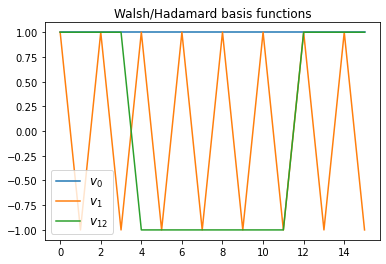

In [8]:
fs = 12
plt.plot(V[:,0], label='$v_0$');
plt.plot(V[:,1], label='$v_1$');
plt.plot(V[:,12],label='$v_{12}$');
plt.title('Walsh/Hadamard basis functions',fontsize=fs)
plt.legend(loc='lower left', fontsize=fs);

## Basis function Coefficients

In [9]:
# initialize some random coefficients
alpha_init = onp.random.rand(num_basis_functions,num_wires,2)
print('alpha shape: (%d, %d, %d) (num_basis_functions, num_wires, num_ops)'%(alpha_init.shape))

alpha shape: (15, 5, 2) (num_basis_functions, num_wires, num_ops)


## Global --> Local transform 
## $ {\cal A} \to \Theta: \quad  {\cal V} \otimes_k {\cal A}= \Theta  $
### $\theta_{l j x} = \sum_k v_{lk} \alpha_{jkx}$

In [10]:
theta_init = np.tensordot(V,alpha_init,([1],[0]))
theta_init.shape

(16, 5, 2)

## Functional Gradient Descent

In [20]:
# GRAFS functions

def grafs_circuit(_alpha):
    # transform global (alpha) --> local (theta)
    theta_ = onp.tensordot(V,_alpha,([1],[0]))
    # evaluate the circuit
    return circuit(theta_)

def grafs_grad(_alpha):
    # alpha --> theta
    theta_ = onp.tensordot(V,_alpha,([1],[0]))
    # compute gradient wrt theta with pennylane/autograd
    cc = qml.grad(circuit)(theta_)[0]
    # complete the chain-rule to get gradient wrt alpha
    return onp.tensordot(V,cc,([0],[0]))

def grafs_step(_alpha,lr):
    # gradient step in function space
    return _alpha - lr*grafs_grad(_alpha)

In [23]:
steps = 35
learning_rate = 0.01

# vanilla gradient descent
opt = qml.GradientDescentOptimizer(learning_rate)

# natural gradient optimizer
# lam is a regularization parameter
opt_ng = qml.QNGOptimizer(learning_rate, lam=0.01)

# alpha --> theta
theta = np.tensordot(V,alpha_init,([1],[0]))

# for natural gradient
theta_ng = theta

gd_cost = []
qng_cost = []
grafs_cost = []

# initial cost
gd_cost.append(circuit(theta))
qng_cost.append(circuit(theta))
grafs_cost.append(grafs_circuit(alpha_init))

alpha = alpha_init

for _ in range(steps):
    #print('%f : %f' %(gd_cost[-1],grafs_cost[-1]))

    # take a theta step
    theta = opt.step(circuit, theta)
    gd_cost.append(circuit(theta))

    # take an alpha step
    alpha = grafs_step(alpha,learning_rate)
    grafs_cost.append(grafs_circuit(alpha))

    # take a natural gradient step
    theta_ng = opt_ng.step(circuit, theta_ng)
    qng_cost.append(circuit(theta_ng))

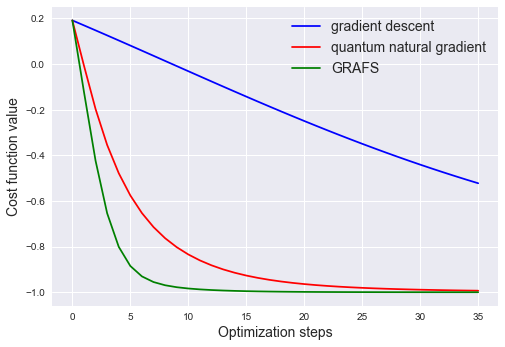

In [24]:
fs = 14
plt.style.use("seaborn")
plt.plot(gd_cost, "b", label="gradient descent")
plt.plot(qng_cost,'r', label="quantum natural gradient")
plt.plot(grafs_cost, "g", label="GRAFS")

plt.ylabel("Cost function value",fontsize=fs)
plt.xlabel("Optimization steps", fontsize=fs)
plt.legend(fontsize=fs);